## ESAT K Estimation Workflow 4 - Factor Distribution Mean

This notebook implements a workflow for estimating the factor count (K) by using the mean value of set of factor occurrence distributions for a range of factor count values.

#### Code Imports

In [6]:
import time
import copy
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from tqdm.notebook import trange
from plotly.subplots import make_subplots
from esat.data.datahandler import DataHandler
from esat.model.batch_sa import BatchSA
from esat.data.analysis import ModelAnalysis, BatchAnalysis
from esat.error.bootstrap import Bootstrap
from esat_eval.simulator import Simulator
from esat_eval.factor_comparison import FactorCompare

In [7]:
# Synethic dataset parameter value ranges
syn_factors_min = 3
syn_factors_max = 8

syn_features_min = 15
syn_features_max = 45

syn_samples_min = 200
syn_samples_max = 1000

outliers = True
outliers_p_min = 0.05
outliers_p_max = 0.1
outliers_mag_min = 1.1
outliers_mag_max = 2

noise_mean_min = 0.05
noise_mean_max = 0.15
noise_scale = 0.01

uncertainty_mean_min = 0.05
uncertainty_mean_max = 0.15
uncertainty_scale = 0.01

contr_curve_min_range = [0.0, 1.0]
contr_curve_max_range = [2.0, 5.0]
contr_curve_scale_range = [0.1, 0.5]

random_seed = 337
k_coef = 0.75

In [8]:
rng = np.random.default_rng(seed=random_seed)

In [11]:
# Initialize the simulator with the above parameters
def generate_synthetic_data(true_factor):
    n_features = rng.integers(low=syn_features_min, high=syn_features_max, size=1)[0]
    n_samples = rng.integers(low=syn_samples_min, high=syn_samples_max, size=1)[0]
    i_outlier_p = round(rng.uniform(low=outliers_p_min, high=outliers_p_max, size=1)[0], 2)
    i_outlier_mag = round(rng.uniform(low=outliers_mag_min, high=outliers_mag_max, size=1)[0], 2)
    contribution_max = round(rng.uniform(low=1.0, high=10.0, size=1)[0], 2)
    print(f"True Factors: {true_factor}, Features: {n_features}, Samples: {n_samples}, Outliers %: {i_outlier_p}, Outliers Magnitude: {i_outlier_mag}, Contribution Max: {contribution_max}")
    simulator = Simulator(seed=rng.integers(low=0, high=10, size=1)[0],
                          factors_n=true_factor,
                          features_n=n_features,
                          samples_n=n_samples,
                          outliers=outliers,
                          outlier_p=i_outlier_p,
                          outlier_mag=i_outlier_mag,
                          contribution_max=contribution_max,
                          noise_mean_min=noise_mean_min,
                          noise_mean_max=noise_mean_max,
                          noise_scale=noise_scale,
                          uncertainty_mean_min=uncertainty_mean_min,
                          uncertainty_mean_max=uncertainty_mean_max,
                          uncertainty_scale=uncertainty_scale,
                          verbose=False
                         )
    curved_factors_count = rng.integers(low=0, high=true_factor, size=1)[0]
    curved_factor_list = rng.choice(list(range(true_factor)), size=curved_factors_count, replace=False)
    for c_i in curved_factor_list:
        # parameters not used by the curve type are ignored
        i_curve_type = rng.choice(['uniform', 'decreasing', 'increasing', 'logistic', 'periodic'], size=1)[0]
        i_curve_min = rng.uniform(low=contr_curve_min_range[0], high=contr_curve_min_range[1], size=1)[0]
        i_curve_max = rng.uniform(low=contr_curve_max_range[0], high=contr_curve_max_range[1], size=1)[0]
        i_curve_scale = rng.uniform(low=contr_curve_scale_range[0], high=contr_curve_scale_range[1], size=1)[0]
        i_curve_frequency = rng.uniform(low=0.1, high=0.9, size=1)[0]
        
        # To keep all as uniform comment out the line below
        # simulator.update_contribution(factor_i=c_i, curve_type=i_curve_type, scale=i_curve_scale, frequency=i_curve_frequency, minimum=i_curve_min, maximum=i_curve_max)
    
    syn_input_df, syn_uncertainty_df = simulator.get_data()
    data_handler = DataHandler.load_dataframe(input_df=syn_input_df, uncertainty_df=syn_uncertainty_df)
    data_handler.metrics
    V, U = data_handler.get_data()
    return V, U

def check_factor_catalog(vk0, factor_catalog, verbose=False):
    best_r2 = 0.0
    mapped_k = -1
    for factor_i, factor_details in factor_catalog.items():
        vk_r2_list = []
        for f_vk in factor_details["Vk"]:
            with np.errstate(divide='ignore', invalid='ignore'):
                vk_r2 = FactorCompare.calculate_correlation(f_vk.flatten(), vk0.flatten())
            vk_r2_list.append(vk_r2)
        vk_r2_mean = np.mean(vk_r2_list)
        if verbose:
            print(f"{factor_i} - R2: {vk_r2_mean}")
        if vk_r2_mean > best_r2:
            best_r2 = vk_r2_mean
            mapped_k = factor_details["idx"]
    return best_r2, mapped_k

def catalog_factors(batch_sa, threshold=0.95):
    f = batch_sa.factors
    factor_n = 0
    factor_catalog = {}
    for i, sa in enumerate(batch_sa.results):
        h_i = sa.H
        norm_hi = h_i / np.sum(h_i, axis=0)
        w_i = sa.W
        for k in range(f):
            hf_i = [h_i[k]]
            wf_i = w_i[:,k]
            wf_i = np.reshape(wf_i, (wf_i.shape[0], 1))
            wh_i = np.matmul(wf_i, hf_i)
            if i == 0:
                factor_catalog[f"Factor {factor_n}"] = {"profile": [norm_hi[k]], "Vk": [wh_i],  "models": [i], "r2": [1.0], "mapping": [k], "idx": factor_n}
            else:
                best_r2, mapped_k = check_factor_catalog(wh_i, factor_catalog)
                if best_r2 > threshold:
                    factor_catalog[f"Factor {mapped_k}"]["profile"].append(norm_hi[k])
                    factor_catalog[f"Factor {mapped_k}"]["models"].append(i)
                    factor_catalog[f"Factor {mapped_k}"]["r2"].append(best_r2)
                    factor_catalog[f"Factor {mapped_k}"]["mapping"].append(k)
                    factor_catalog[f"Factor {mapped_k}"]["Vk"].append(wh_i)
                else:
                    factor_catalog[f"Factor {factor_n}"] = {"profile": [norm_hi[k]], "Vk": [wh_i], "models": [i], "r2": [1.0], "mapping": [k], "idx": factor_n}
                    factor_n += 1
    return factor_catalog


def run_batch(v, u, ifactors, random_seed, models=10, max_iter=10000, converge_n=20, converge_delta=0.1, threshold: float=0.9):
    sa_models = BatchSA(V=v, U=u, factors=ifactors, models=models, method="ls-nmf", seed=random_seed, max_iter=max_iter,
                        converge_delta=converge_delta, converge_n=converge_n, optimized=True,
                        verbose=False
                       )
    _ = sa_models.train()
    
    f_catalog = catalog_factors(batch_sa=sa_models, threshold=threshold)
    factor_occurrence = [round(100 * len(f["models"])/models, 2) for _, f in f_catalog.items()]
    factor_count = [len(f["models"]) for _, f in f_catalog.items()]
    factor_mean_r2 = [round(np.mean(f["r2"]), 4) for _, f in f_catalog.items()]
    profiles_df = pd.DataFrame(data={"factors": f_catalog.keys(), "count": factor_count,  "% occurrence": factor_occurrence, "mean R2": factor_mean_r2})
    profiles_df_sorted = profiles_df.sort_values(by='% occurrence', ascending=False)
    return sa_models, f_catalog, profiles_df_sorted

def run_batch_range(k, iV, iU, min_k: int = 2, max_k: int = 10, models: int = 10, max_iter=10000, converge_n=20, converge_delta=0.1, threshold: float = 0.9):
    results = {
        "true_k": k,
        "models": models,
        "min_k": min_k,
        "max_k": max_k,
        "k_results": []
    }
    for ifactors in trange(min_k, max_k+1, desc="Running Batch K-Estimate using Factor Catalog"):
        i_seed = rng.integers(low=0, high=1e10, endpoint=True, size=1)[0]
        i_result = run_batch(v=iV, u=iU, ifactors=ifactors, random_seed=i_seed, models=models, max_iter=max_iter, converge_n=converge_n, converge_delta=converge_delta, threshold=threshold)
        results["k_results"].append(i_result)
    return results
    

In [52]:
%%time
true_k = 8
iV, iU = generate_synthetic_data(true_factor=true_k)

n_models = 100
threshold = 0.9
min_factors = 2
max_factors = 12

batch_estimate = run_batch_range(k=true_k, iV=iV, iU=iU, min_k=min_factors, max_k=max_factors, models=n_models, max_iter=10000, converge_n=20, converge_delta=0.1, threshold=threshold)

True Factors: 8, Features: 35, Samples: 955, Outliers %: 0.06, Outliers Magnitude: 1.25, Contribution Max: 4.01


Running Batch K-Estimate using Factor Catalog:   0%|          | 0/11 [00:00<?, ?it/s]

CPU times: total: 46min 18s
Wall time: 1h 55min 3s


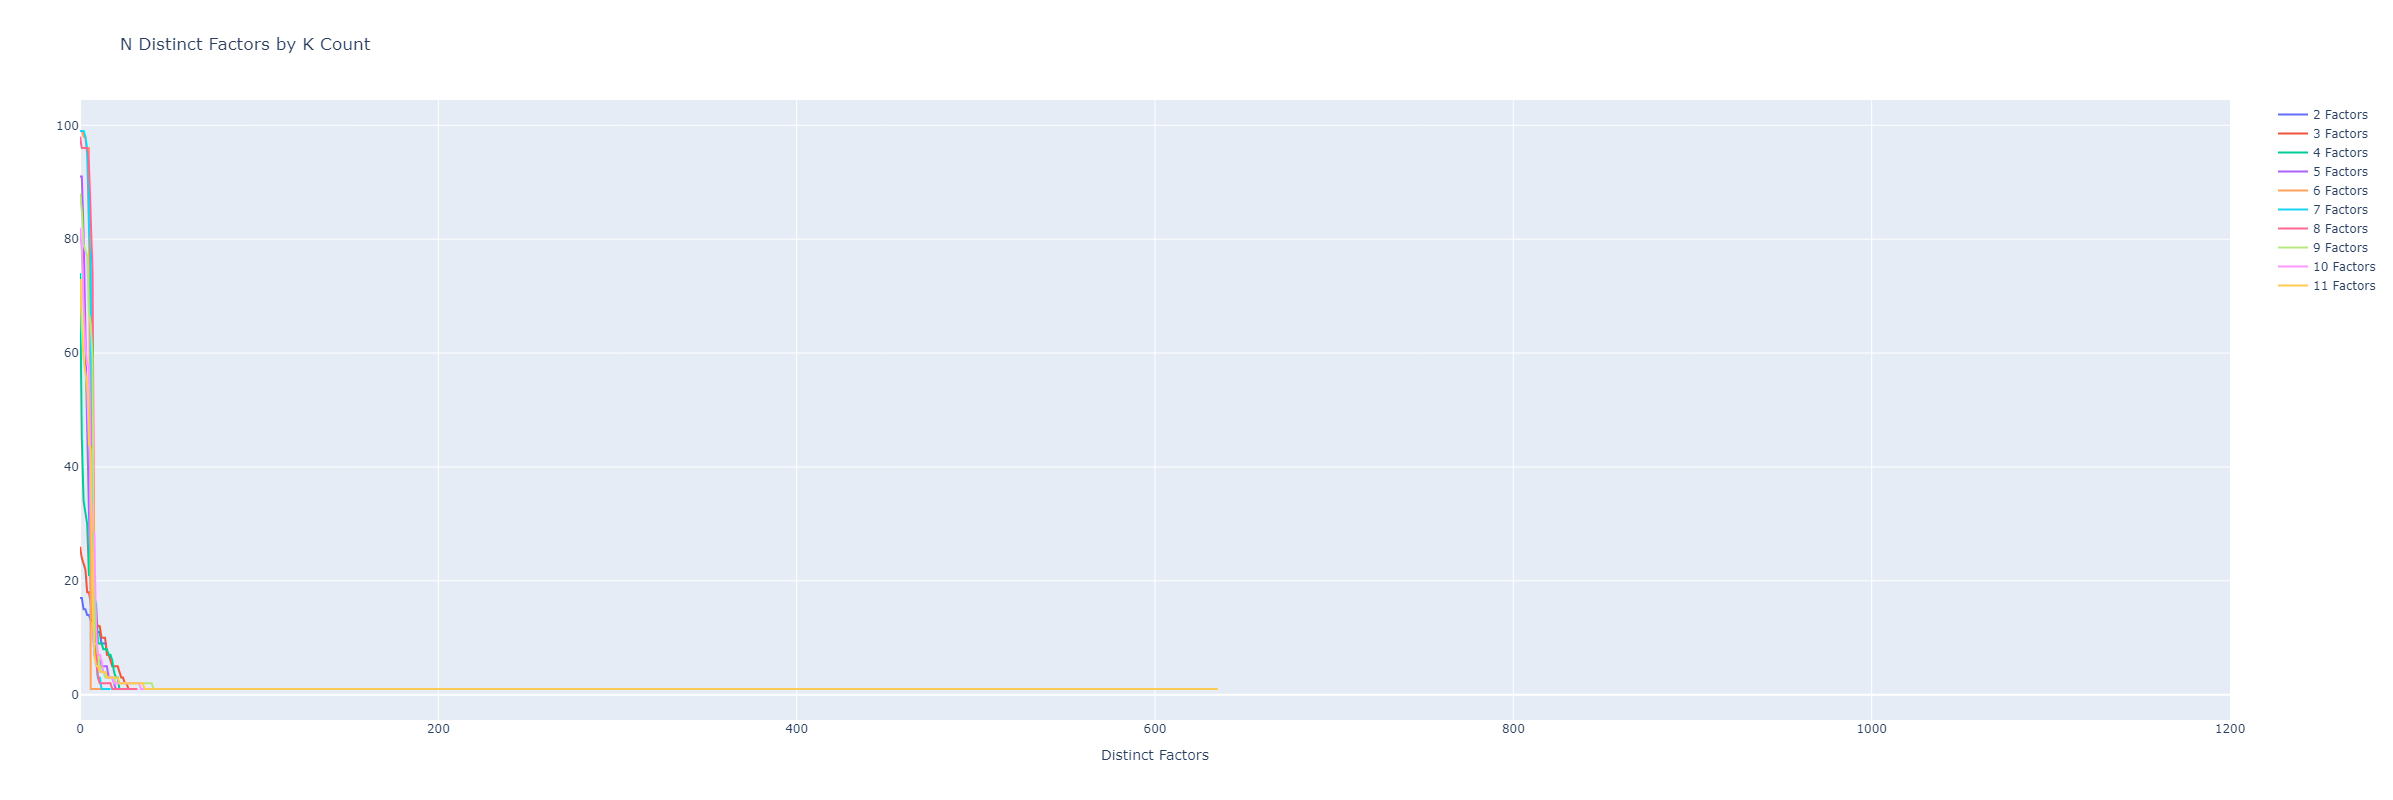

In [53]:
x_list = list(range(n_models*max_factors))

batch_fig = go.Figure()
for i in range(max_factors-min_factors):
    batch_dist = batch_estimate["k_results"][i][2]["count"].values
    batch_fig.add_trace(go.Scatter(x=x_list, y=batch_dist, name=f"{min_factors+i} Factors", mode="lines"))
batch_fig.update_layout(title="N Distinct Factors by K Count", width=1200, height=800, hovermode='x unified')
batch_fig.update_xaxes(title_text="Distinct Factors", range=[0, n_models*max_factors])
batch_fig.show()

In [54]:
factor_metrics = None

factor_labels = []
batch_mean = []
batch_std = []
batch_var = []
batch_median = []
for i in range(max_factors-min_factors):
    batch_dist = batch_estimate["k_results"][i][2]["count"].values
    b_mean = np.mean(batch_dist)
    b_std = np.std(batch_dist)
    b_var = np.var(batch_dist)
    b_median = np.median(batch_dist)
    batch_mean.append(b_mean)
    batch_std.append(b_std)
    batch_var.append(b_var)
    batch_median.append(b_median)
    factor_labels.append(f"{min_factors+i} Factors")
results_df = pd.DataFrame(data={"Factors": factor_labels, "Mean": batch_mean, "STD": batch_std, "Var": batch_var, "Median": batch_median})
results_df

,Factors,Mean,STD,Var,Median
0,2 Factors,12.375000,2.689679,7.234375,12.0
1,3 Factors,9.900000,7.309127,53.423333,8.5
2,4 Factors,14.666667,16.339001,266.962963,8.0
3,5 Factors,21.521739,29.677791,880.771267,6.0
4,6 Factors,42.428571,47.844561,2289.102041,1.0
5,7 Factors,38.500000,43.471894,1889.805556,10.5
6,8 Factors,24.000000,38.650728,1493.878788,2.0
7,9 Factors,3.775424,13.444030,180.741938,1.0
8,10 Factors,2.224719,8.127292,66.052872,1.0
9,11 Factors,1.712264,5.875590,34.522554,1.0


In [55]:
predicted_k = results_df.loc[results_df["Mean"].idxmax()]["Factors"]
print(f"Predicted K: {predicted_k}")

Predicted K: 6 Factors
